In [48]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [2]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['.'] = 0
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())

In [5]:
# build the dataset

BLOCK_SIZE = 8 # context size to give the model in order to predict the next character

def build_dataset(corpus, block_size, codebook, padding_char="."):
    X, Y = [], []
    for word in corpus:
        start_padding = padding_char * block_size
        padded_word = f"{start_padding}{word}."
        tokenized_word = [codebook[c] for c in padded_word]
        for i in range(len(tokenized_word)-block_size):
            X.append(tokenized_word[i:i+block_size])
            Y.append(tokenized_word[i+block_size])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

torch.Size([182578, 8]) torch.Size([182578])
torch.Size([22795, 8]) torch.Size([22795])
torch.Size([22773, 8]) torch.Size([22773])


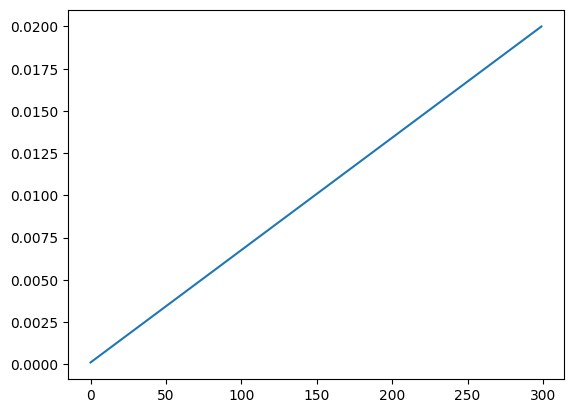

In [34]:
beta_start, beta_stop = 1e-4, 2e-2
beta_timesteps = 300
betas = torch.linspace(beta_start, beta_stop, beta_timesteps)
plt.plot(betas)

In [47]:
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

torch.Size([8, 16])


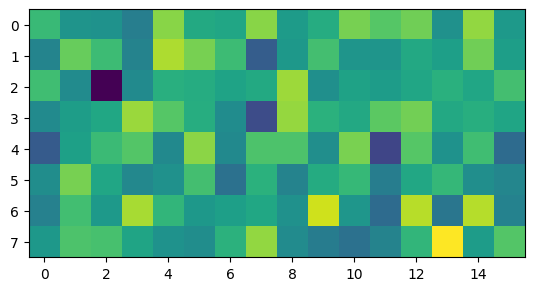

In [148]:
EMBEDDING_DIMS = 16
embedding_layer = nn.Embedding(TOTAL_TOKENS, EMBEDDING_DIMS)

x_index = 109943 # torch.randint(x_train.shape[0], (1,))
x_example = x_train[x_index]
x_embedded = embedding_layer(x_example)
plt.imshow(x_embedded.squeeze().detach())

In [79]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

/var/folders/s0/t86zqyvd40gcw4j03vh3gzrw0000gp/T/ipykernel_23649/3884242489.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, (idx//stepsize) + 1)


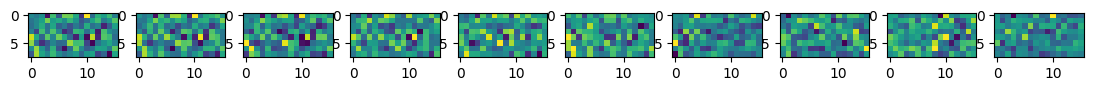

In [137]:
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = beta_timesteps//num_images

for idx in range(0, beta_timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx//stepsize) + 1)
    im, noise = forward_diffusion_sample(x_embedded, t)
    plt.imshow(im.squeeze().detach())

In [162]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        c = self.conv1(x)
        r = self.relu(c)
        #print(r.shape)
        h = self.bnorm1(r)
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self,
                 image_channels = 3,
                 out_dim=1,
                 time_emb_dim=32,
                 up_channels=(64, 128, 256, 512, 1024), 
                 down_channels=(1024, 512, 256, 128, 64)
                ):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], image_channels, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            #print('residual', x.shape, residual_x.shape)
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

channels = (8, 16, 32)
model = SimpleUnet(up_channels=channels, down_channels=channels[::-1], image_channels=1, time_emb_dim=8)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  58857


In [112]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [113]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise          

In [150]:
x_embedded[None,None,...].shape

torch.Size([1, 1, 8, 16])

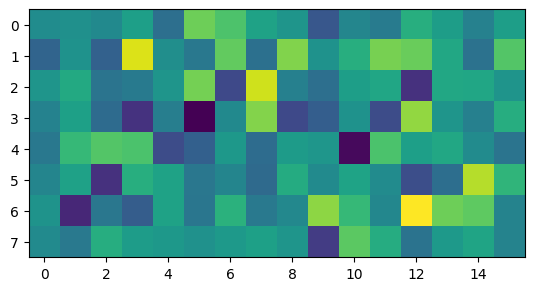

In [147]:
device = 'cpu'
t = torch.randint(0, beta_timesteps, (1,), device=device).long()
#print(x_embedded[None,None,...].shape)
x_noisy, noise = forward_diffusion_sample(x_embedded[None,...], t, device)
noise_pred = model(x_noisy, t)

plt.imshow(noise_pred.squeeze().detach());

In [164]:
from torch.optim import Adam

#device = "cuda" if torch.cuda.is_available() else "cpu"

model = SimpleUnet(up_channels=channels, down_channels=channels[::-1], image_channels=1, time_emb_dim=8)

device = "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
steps = 10000
BATCH_SIZE = 32

for step in range(steps):
    
    optimizer.zero_grad()
    
    t = torch.randint(0, beta_timesteps, (BATCH_SIZE,), device=device).long()
    batch_ix = torch.randint(0, x_train.shape[0], (BATCH_SIZE,))
    batch = x_train[batch_ix]
    batch_embedded = embedding_layer(batch)
    
    loss = get_loss(model, batch_embedded[:,None,...], t)
    
    loss.backward()
    optimizer.step()

    if step % 250 == 0:
        print(f"step {step}: {loss.item()}")

step 0: 0.7911100387573242
step 250: 0.35199522972106934
step 500: 0.34414932131767273
step 750: 0.2860214114189148
step 1000: 0.3136037588119507
step 1250: 0.2842950224876404
step 1500: 0.2912517189979553
step 1750: 0.3267157971858978
step 2000: 0.3031754493713379
step 2250: 0.3015476167201996
step 2500: 0.35276469588279724
step 2750: 0.3145018219947815
step 3000: 0.25434020161628723
step 3250: 0.24324297904968262
step 3500: 0.2618792653083801
step 3750: 0.25687190890312195
step 4000: 0.25718939304351807
step 4250: 0.3211295008659363
step 4500: 0.30174264311790466
step 4750: 0.2916986346244812
step 5000: 0.3154556453227997
step 5250: 0.24920544028282166
step 5500: 0.2835516035556793
step 5750: 0.27838122844696045
step 6000: 0.2881258428096771
step 6250: 0.29483261704444885
step 6500: 0.29032379388809204
step 6750: 0.19222599267959595
step 7000: 0.2453722506761551
step 7250: 0.23802237212657928
step 7500: 0.2851432263851166
step 7750: 0.2646787762641907
step 8000: 0.24388152360916138
s

/var/folders/s0/t86zqyvd40gcw4j03vh3gzrw0000gp/T/ipykernel_23649/2881249797.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i//stepsize+1)


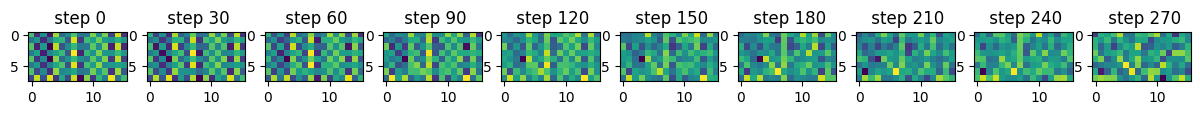

In [179]:
def embedding_to_string(xemb):
    distance = torch.norm(embedding_layer.weight.data[None,...] - xemb[:,None,...], dim=2)
    nearest = torch.argmin(distance, dim=1)
    return "".join([char_lookup[n] for n in nearest.tolist()])

@torch.no_grad()
def sample_model():
    # Sample noise
    img = torch.randn((1, 1, BLOCK_SIZE, EMBEDDING_DIMS), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(beta_timesteps/num_images)

    for i in range(0,beta_timesteps)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i//stepsize+1)
            plt.title(f" step {i}")
            plt.imshow(img.detach().cpu().squeeze())
    plt.show()   
    return img.squeeze()
    
emb = sample_model()

In [220]:
def embedding_to_string(xemb):
    distance = torch.norm(embedding_layer.weight.data[None,...] - xemb[:,None,...], dim=2)
    nearest = torch.argmin(distance, dim=1)
    return "".join([char_lookup[n] for n in nearest.tolist()])

embedding_to_string(embedding_layer(x_example).squeeze().detach())

'.scotlyn'

In [222]:
embedding_to_string(emb)

'.......n'